In [1]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

{}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ruizgara/socofing
!unzip socofing.zip

Streaming output truncated to the last 5000 lines.
  inflating: socofing/SOCOFing/Real/191__F_Left_index_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Left_little_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Left_middle_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Left_ring_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Left_thumb_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_index_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_little_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_middle_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_ring_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_thumb_finger.BMP  
  inflating: socofing/SOCOFing/Real/192__M_Left_index_finger.BMP  
  inflating: socofing/SOCOFing/Real/192__M_Left_little_finger.BMP  
  inflating: socofing/SOCOFing/Real/192__M_Left_middle_finger.BMP  
  inflating: socofing/SOCOFing/Real/192__M_Left_ring_finger.BMP  
  i

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from utils import View
from utils import train_network
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import os
from torchvision.io import read_image
from torch.utils.data import Dataset
import os
import random
import torch
from torchvision import transforms
from PIL import Image
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



/content/utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
directory_path = '/content/SOCOFing/Real'

def count_files_in_directory(directory_path):
    file_count = 0

    # Iterate through all items (files and directories) in the given directory
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)

        if os.path.isfile(item_path):
            # If it's a file, increment the file count
            file_count += 1
        elif os.path.isdir(item_path):
            # If it's a directory, recursively count files in that directory
            file_count += count_files_in_directory(item_path)

    return file_count

directory_path = directory_path
total_file_count = count_files_in_directory(directory_path)
print("Total number of files in directory and its subdirectories:", total_file_count)



Total number of files in directory and its subdirectories: 6000


## lets iterate through the images and show some of them with their dimensions to get a view of the shape of out dataset

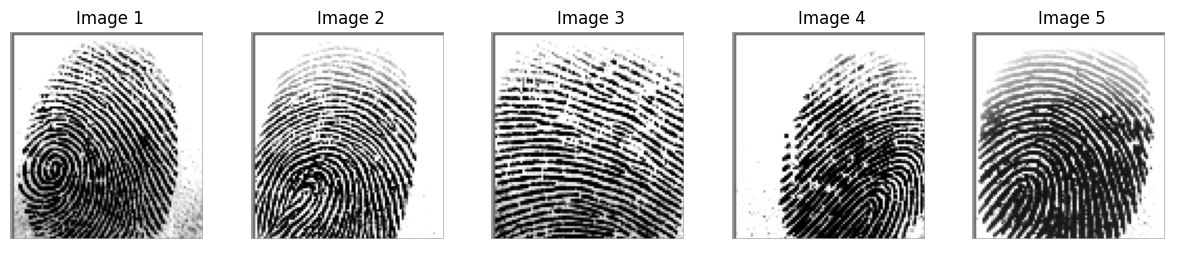

Image 1 Dimensions: 96 x 103 pixels
Image 2 Dimensions: 96 x 103 pixels
Image 3 Dimensions: 96 x 103 pixels
Image 4 Dimensions: 96 x 103 pixels
Image 5 Dimensions: 96 x 103 pixels


In [9]:
def find_bmp_files(directory_path):
    bmp_files = []

    # Recursively find .bmp files in the directory and its subdirectories
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".BMP"):
                bmp_files.append(os.path.join(root, file))

    return bmp_files

def display_random_sample(bmp_files, sample_size):
    # Use random.sample to get a random sample of .bmp files
    sample = random.sample(bmp_files, sample_size)

    # Create subplots to display images
    fig, axes = plt.subplots(1, sample_size, figsize=(15, 5))  # Adjust the figsize as needed

    for i, file_path in enumerate(sample):
        img = Image.open(file_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis("off")

    plt.show()

def get_dimensions_of_sample(bmp_files, sample_size):
    # Use random.sample to get a random sample of .bmp files
    sample = random.sample(bmp_files, sample_size)

    for i, file_path in enumerate(sample):
        img = Image.open(file_path)
        width, height = img.size
        print(f"Image {i+1} Dimensions: {width} x {height} pixels")

directory_path = '/content/SOCOFing/Real'
bmp_files = find_bmp_files(directory_path)

if len(bmp_files) == 0:
    print("No .bmp files found in the specified directory and its subdirectories.")
else:
    sample_size = 5  # Change this to the desired sample size
    display_random_sample(bmp_files, sample_size)
    get_dimensions_of_sample(bmp_files, sample_size)


## let's Iterate through the .bmp files and convert them to PIL images

In [10]:
# Directory containing .bmp images
directory_path = '/content/SOCOFing/Real'

# List all .bmp files in the directory
bmp_files = [f for f in os.listdir(directory_path) if f.endswith('.BMP')]

# Iterate through the .bmp files and convert them to PIL images
pil_images = []
for bmp_file in bmp_files:
    bmp_path = os.path.join(directory_path, bmp_file)
    pil_image = Image.open(bmp_path)
    pil_images.append(pil_image)

# Now, pil_images is a list of PIL images

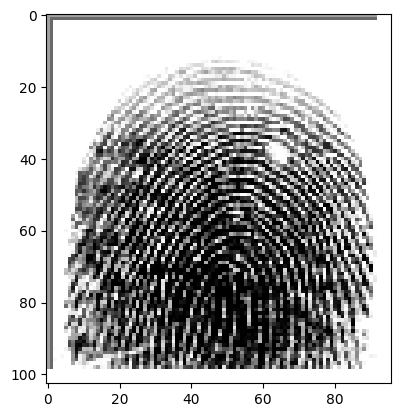

In [11]:
 plt.imshow(pil_images[0])

## The next cell is to convert the images to .PNG format

In [12]:
# Png formatting for the dataset


# Directory containing .bmp images
input_directory = '/content/SOCOFing/Real'

# Directory to save the converted .png images
output_directory = '/content/data/'

# Ensure the output directory exists, or create it if it doesn't
os.makedirs(output_directory, exist_ok=True)

# List all .bmp files in the input directory
bmp_files = [f for f in os.listdir(input_directory) if f.endswith('.BMP')]

# Iterate through the .bmp files and convert them to .png
for bmp_file in bmp_files:
    bmp_path = os.path.join(input_directory, bmp_file)
    # Open the BMP image
    bmp_image = Image.open(bmp_path)

    # Create the output path by replacing the .bmp extension with .png
    png_file = os.path.splitext(bmp_file)[0] + '.png'
    png_path = os.path.join(output_directory, png_file)

    # Save the image as .png
    bmp_image.save(png_path, 'PNG')

print(f"{len(bmp_files)} .BMP images converted to .PNG and saved in {output_directory}")


6000 .BMP images converted to .PNG and saved in /content/data/


## showing a sample of the .PNG images and their dimensions

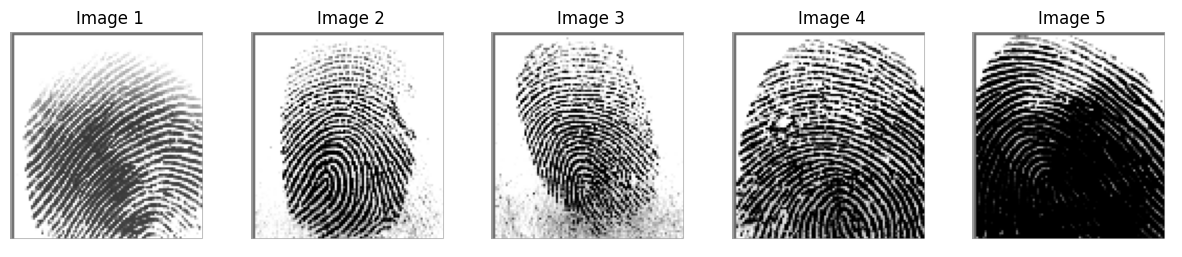

Image 1 Dimensions: 96 x 103 pixels
Image 2 Dimensions: 96 x 103 pixels
Image 3 Dimensions: 96 x 103 pixels
Image 4 Dimensions: 96 x 103 pixels
Image 5 Dimensions: 96 x 103 pixels


In [13]:
def find_bmp_files(directory_path):
    bmp_files = []

    # Recursively find .bmp files in the directory and its subdirectories
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".png"):
                bmp_files.append(os.path.join(root, file))

    return bmp_files

def display_random_sample(bmp_files, sample_size):
    # Use random.sample to get a random sample of .bmp files
    sample = random.sample(bmp_files, sample_size)

    # Create subplots to display images
    fig, axes = plt.subplots(1, sample_size, figsize=(15, 5))  # Adjust the figsize as needed

    for i, file_path in enumerate(sample):
        img = Image.open(file_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis("off")

    plt.show()

def get_dimensions_of_sample(bmp_files, sample_size):
    # Use random.sample to get a random sample of .bmp files
    sample = random.sample(bmp_files, sample_size)

    for i, file_path in enumerate(sample):
        img = Image.open(file_path)
        width, height = img.size
        print(f"Image {i+1} Dimensions: {width} x {height} pixels")

directory_path = '/content/data'
bmp_files = find_bmp_files(directory_path)

if len(bmp_files) == 0:
    print("No .png files found in the specified directory and its subdirectories.")
else:
    sample_size = 5  # Change this to the desired sample size
    display_random_sample(bmp_files, sample_size)
    get_dimensions_of_sample(bmp_files, sample_size)


In [15]:
# Root directory containing the .png images
root_dir = '/content/data'

# List all .png image files in the directory
png_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

# Pick a random image from the list
random_image_file = random.choice(png_files)

# Full path to the randomly selected image
image_path = os.path.join(root_dir, random_image_file)

# Define the transformation (if needed)
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

# Load the image using PIL
image = Image.open(image_path)

# Apply the transformation (if needed)
if transform:
    image = transform(image)

# Get the shape of the image tensor
image_shape = image.shape

print(f"Random Image: {random_image_file}")
print(f"Image Shape: {image_shape}")


Random Image: 322__M_Left_index_finger.png
Image Shape: torch.Size([4, 50, 50])


In [16]:
class AutoEncodeDataset(Dataset):
    """Takes a dataset with (x, y) label pairs and converts it to (x, x) pairs.
    This makes it easy to re-use other code"""

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.__getitem__(idx)
        return x, x # just throw away the original label.

In [17]:
class CustomPNGImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image


global_img_size = (90, 90)
# Define the transformation
transform = transforms.Compose([
    transforms.Resize(global_img_size),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Directory containing .png images
data_dir = '/content/data'

# Create a custom dataset using CustomPNGImageDataset
dataset = CustomPNGImageDataset(root_dir=data_dir, transform=transform)

# Split the dataset
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True)


train_data = AutoEncodeDataset(train_dataset)
test_data = AutoEncodeDataset(val_dataset)
# Create a DataLoader to iterate over the dataset
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

torch.Size([1, 90, 90])


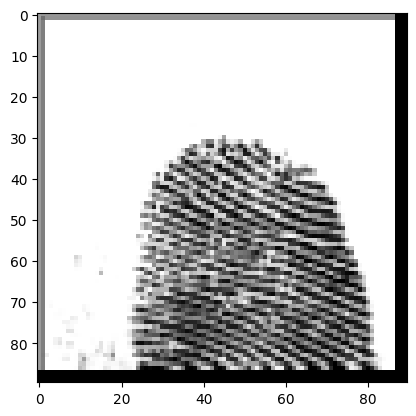

In [29]:
# Iterate over the dataloader
x = next(iter(train_loader))
print(x[0][0].shape)
plt.imshow(x[0][0].reshape(90,90,1),cmap='gray')

# now we're done with making the dataset ready

In [19]:
def get_layer(in_size,out_size):
    """
    in_size: how many neurons/features are coming into this layer
    out_size: how many neurons/outputs this hidden layer should produce
    """
    return nn.Sequential(
        nn.Linear(in_size,out_size),
        nn.BatchNorm1d(out_size),
        nn.ReLU()
    )

In [20]:
D = 90*90 # images size
n=2 # bottleneck
auto_encoder = nn.Sequential(
    nn.Flatten(),
    get_layer(D,D//2),
    get_layer(D//2,D//3),
    get_layer(D//3,D//4),
    get_layer(D//4,D//6),
    get_layer(D//6,D//8),
    nn.Linear(D//8,n)
)

auto_decoder = nn.Sequential(
    get_layer(n,D//8),
    get_layer(D//8,D//6),
    get_layer(D//6,D//4),
    get_layer(D//4,D//3),
    get_layer(D//3,D//2),
    nn.Linear(D//2,D),
    View(-1,1,90,90)
)

In [21]:
auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)

In [22]:
train_network(model=auto_encode_decode,loss_func=nn.MSELoss(),
            train_loader=train_loader,
            test_loader=test_loader,
            epochs=3,
            device=device)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/150 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/150 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/150 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

,epoch,total time,train loss,test loss
0,0,7.719930,0.108476,0.069777
1,1,14.883838,0.065163,0.056913
2,2,21.954774,0.055996,0.053458


In [23]:
def encode_batch(encoder,dataset_to_encode):
    """
    encoder: the PyTorch network that takes in a dataset and convers it to a new dimension
    dataset_to_encode: a PyTorch `Dataset` object that we want to convert.

    Returns a tuple (projected, labels) where `projected` is the encoded version of the dataset,
    and `labels` are the original labels provided by the `dataset_to_encode`
    """
    projected = []
    labels = []
    # put the encode to evaluation mode and pass it to the cpu
    encoder = encoder.eval()
    encoder = encoder.cpu()
    with torch.inference_mode():
        for x,y in DataLoader(dataset_to_encode,batch_size=128):
            z = encoder(x.cpu()) # move x to cpu just in case it wasn't already there
            projected.append(z.numpy())
            labels.append(y.cpu().numpy().ravel())

    projected = np.vstack(projected)
    labels = np.hstack(labels)

    return projected , labels

In [24]:
projected , labels = encode_batch(auto_encode_decode,test_data)
projected.shape , projected.ndim

((1200, 1, 90, 90), 4)

In [25]:
def show_encode_decode(encode_decode,x):
    """
    encode_decode: the PyTorch Module that does the encoding and decoding steps at once
    x: the input to plot as is, and after encoding & decoding it
    """
    encode_decode = encode_decode.eval()
    encode_decode = encode_decode.cpu()
    with torch.inference_mode():
        x_recon = encode_decode(x.cpu())
        f , axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

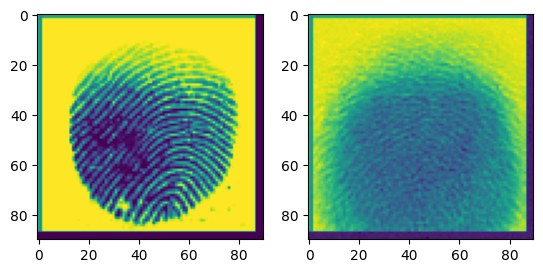

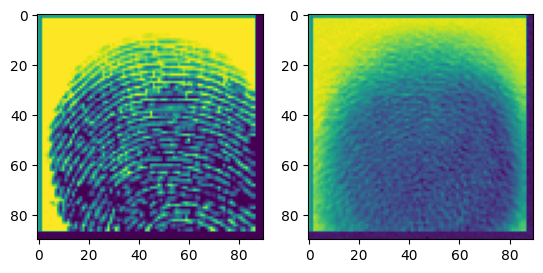

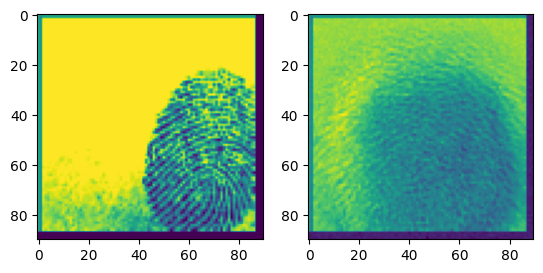

In [26]:
show_encode_decode(auto_encode_decode,test_data[0][0])
show_encode_decode(auto_encode_decode,test_data[1][0])
show_encode_decode(auto_encode_decode,test_data[2][0])

# This part to add noise to a ceratain sample and see how the network works with that

In [27]:
# add noise function
normal = torch.distributions.Normal(0,0.5)
def addNoise(x,device='cpu'):
    """
    We will use this helper function to add noise to some data.
    x: the data we want to add noise to
    device: the CPU or GPU that the input is located on.
    """
    return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)

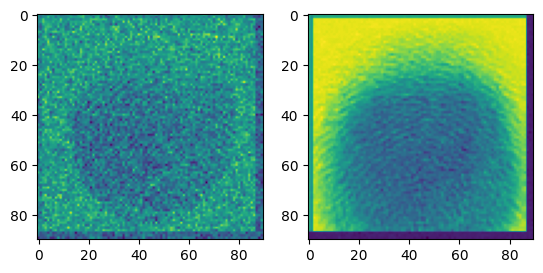

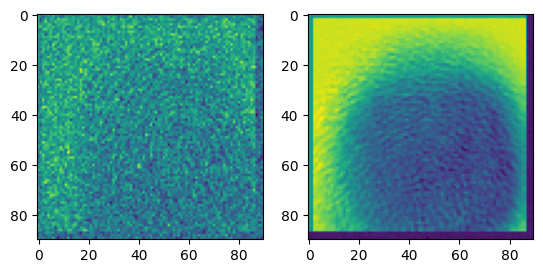

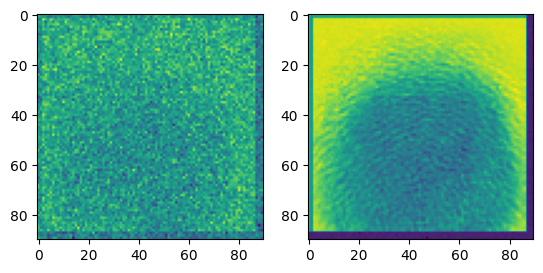

In [28]:
show_encode_decode(auto_encode_decode,addNoise(test_data[0][0]))
show_encode_decode(auto_encode_decode,addNoise(test_data[19][0]))
show_encode_decode(auto_encode_decode,addNoise(test_data[60][0]))